Load the libraries we need

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import MetaTrader5 as mt5
from   datetime import datetime
import seaborn as sns
import time

Setup log in details

In [2]:
account = 30516497
password = "4ATSm7pPxK4iuW5*"
server = "Deriv-Demo"

In [3]:
if(mt5.initialize(login=account,password=password,server=server)):
    print("Logged in succesfully")
else:
    print("Failed to login")

Logged in succesfully


Market data

In [4]:
timeframe = mt5.TIMEFRAME_M15
deviation = 1000
volume = 0
lot_multiple = 10
symbol = "EURUSD"

In [5]:
#Setup trading volume
symbols = mt5.symbols_get()
for index,symbol in enumerate(symbols):
    if symbol.name == "EURUSD":
        print(f"{symbol.name} has minimum volume: {symbol.volume_min}")
        volume = symbol.volume_min * lot_multiple

EURUSD has minimum volume: 0.01


Get Training Data

In [7]:
#Specify date range of data to be modelled
date_start = datetime(2020,1,1)
date_end = datetime.now()

In [6]:
#Define how far ahead we are looking
look_ahead = 20

In [11]:
#Fetch market data
market_data = pd.DataFrame(mt5.copy_rates_range("EURUSD",timeframe,date_start,date_end))
market_data["time"] = pd.to_datetime(market_data["time"],unit='s')
#Add simple moving average technical indicator
market_data.ta.sma(length=5,append=True)
#Add simple moving average technical indicator
market_data.ta.sma(length=50,append=True)
#Delete missing rows
market_data.dropna(inplace=True)
#Add a column for the target
market_data["target"] = 0
market_data["close_target"] = 0
#Encoding the target
ma_cross_conditions = [
    (market_data["SMA_5"].shift(-look_ahead) > market_data["SMA_50"].shift(-look_ahead)),
    (market_data["SMA_5"].shift(-look_ahead) < market_data["SMA_50"].shift(-look_ahead))
]
#Encoding pattern
ma_cross_choices = [
    #Fast MA above Slow MA
    1,
    #Fast MA below Slow MA
    0
]

price_conditions = [
    (market_data["close"] > market_data["close"].shift(-look_ahead)),
    (market_data["close"] < market_data["close"].shift(-look_ahead))
]

#Encoding pattern
price_choices = [
    #Price fell
    0,
    #Price rose
    1
]

market_data["target"] = np.select(ma_cross_conditions,ma_cross_choices)
market_data["close_target"] = np.select(price_conditions,price_choices)

#The last rows do not have answers
market_data = market_data[:-look_ahead]
market_data

time     open     high      low    close  tick_volume  \
49     2020-01-02 10:00:00  1.12032  1.12040  1.12012  1.12013          373   
50     2020-01-02 10:15:00  1.12013  1.12014  1.11929  1.11934          562   
51     2020-01-02 10:30:00  1.11934  1.11962  1.11929  1.11941          500   
52     2020-01-02 10:45:00  1.11941  1.11999  1.11937  1.11984          400   
53     2020-01-02 11:00:00  1.11986  1.12023  1.11969  1.12005          635   
...                    ...      ...      ...      ...      ...          ...   
111472 2024-06-25 06:00:00  1.07418  1.07418  1.07356  1.07358         1542   
111473 2024-06-25 06:15:00  1.07358  1.07378  1.07343  1.07348          657   
111474 2024-06-25 06:30:00  1.07348  1.07363  1.07323  1.07360          645   
111475 2024-06-25 06:45:00  1.07360  1.07378  1.07314  1.07320         1085   
111476 2024-06-25 07:00:00  1.07319  1.07329  1.07274  1.07278         1807   

        spread  real_volume     SMA_5    SMA_50  target  close_target  
49          50            0  1.120624  1.121251       0             0  
50          50            0  1.120278  1.121238       0             0  
51          50            0  1.119958  1.121205       0             0  
52          50            0  1.119808  1.121173       0             1  
53          50            0  1.119754  1.121144       0             0  
...        ...          ...       ...       ...     ...           ...  
111472       0            0  1.074098  1.073510       0             0  
111473       0            0  1.073960  1.073529       0             0  
111474       0            0  1.073812  1.073550       0             0  
111475       0            0  1.073606  1.073551       0             0  
111476       0            0  1.073328  1.073536       0             0  

[111428 rows x 12 columns]

Importing Libraries

In [27]:
#XGBoost
from xgboost import XGBClassifier
#Catboost
from catboost import CatBoostClassifier
#Random forest
from sklearn.ensemble import RandomForestClassifier
#LDA and QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis , QuadraticDiscriminantAnalysis
#Logistic regression
from sklearn.linear_model import LogisticRegression
#Neural network
from sklearn.neural_network import MLPClassifier
#Time series split
from sklearn.model_selection import TimeSeriesSplit
#Accuracy metrics
from sklearn.metrics import accuracy_score
#Visualising performance
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

Setting up Time Series Split

In [34]:
#Time series split
splits = 10
gap = look_ahead

In [35]:
models = ["Logistic Regression","Linear Discriminant Analysis","Quadratic Discriminant Analysis","Random Forest Classifier","XGB Classifier","Cat Boost Classifier","Neural Network Small","Neural Network Large"]

Data Frame To Store Model Performance

In [36]:
error_ma_crossover = pd.DataFrame(index=np.arange(0,splits),columns=models)
error_ma_crossover

Logistic Regression Linear Discriminant Analysis  \
0                 NaN                          NaN   
1                 NaN                          NaN   
2                 NaN                          NaN   
3                 NaN                          NaN   
4                 NaN                          NaN   
5                 NaN                          NaN   
6                 NaN                          NaN   
7                 NaN                          NaN   
8                 NaN                          NaN   
9                 NaN                          NaN   

  Quadratic Discriminant Analysis Random Forest Classifier XGB Classifier  \
0                             NaN                      NaN            NaN   
1                             NaN                      NaN            NaN   
2                             NaN                      NaN            NaN   
3                             NaN                      NaN            NaN   
4                             NaN                      NaN            NaN   
5                             NaN                      NaN            NaN   
6                             NaN                      NaN            NaN   
7                             NaN                      NaN            NaN   
8                             NaN                      NaN            NaN   
9                             NaN                      NaN            NaN   

  Cat Boost Classifier Neural Network Small Neural Network Large  
0                  NaN                  NaN                  NaN  
1                  NaN                  NaN                  NaN  
2                  NaN                  NaN                  NaN  
3                  NaN                  NaN                  NaN  
4                  NaN                  NaN                  NaN  
5                  NaN                  NaN                  NaN  
6                  NaN                  NaN                  NaN  
7                  NaN                  NaN                  NaN  
8                  NaN                  NaN                  NaN  
9                  NaN                  NaN                  NaN

In order to have a benchmark to compare our performance we will repeat the same test with the actuall change in original price as the target

In [37]:
error_price = pd.DataFrame(index=np.arange(0,splits),columns=models)
error_price

Logistic Regression Linear Discriminant Analysis  \
0                 NaN                          NaN   
1                 NaN                          NaN   
2                 NaN                          NaN   
3                 NaN                          NaN   
4                 NaN                          NaN   
5                 NaN                          NaN   
6                 NaN                          NaN   
7                 NaN                          NaN   
8                 NaN                          NaN   
9                 NaN                          NaN   

  Quadratic Discriminant Analysis Random Forest Classifier XGB Classifier  \
0                             NaN                      NaN            NaN   
1                             NaN                      NaN            NaN   
2                             NaN                      NaN            NaN   
3                             NaN                      NaN            NaN   
4                             NaN                      NaN            NaN   
5                             NaN                      NaN            NaN   
6                             NaN                      NaN            NaN   
7                             NaN                      NaN            NaN   
8                             NaN                      NaN            NaN   
9                             NaN                      NaN            NaN   

  Cat Boost Classifier Neural Network Small Neural Network Large  
0                  NaN                  NaN                  NaN  
1                  NaN                  NaN                  NaN  
2                  NaN                  NaN                  NaN  
3                  NaN                  NaN                  NaN  
4                  NaN                  NaN                  NaN  
5                  NaN                  NaN                  NaN  
6                  NaN                  NaN                  NaN  
7                  NaN                  NaN                  NaN  
8                  NaN                  NaN                  NaN  
9                  NaN                  NaN                  NaN

Proceeding With Model Cross-Validation

In [38]:
predictors = ["open","high","low","close","tick_volume","spread","SMA_5","SMA_50"]

In [39]:
tscv = TimeSeriesSplit(n_splits=splits,gap=gap)

In [64]:
#Training each model to predict changes in the moving average cross over
for i,(train,test) in enumerate(tscv.split(market_data)):
    model = MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(20, 10), random_state=1,early_stopping=True)
    model.fit( market_data.loc[train[0]:train[-1],predictors] , market_data.loc[train[0]:train[-1],"target"] ) 
    error_ma_crossover.iloc[i,7] = accuracy_score(market_data.loc[test[0]:test[-1],"target"],model.predict(market_data.loc[test[0]:test[-1],predictors]))

In [65]:
#Training each model to predict changes in the close price
for i,(train,test) in enumerate(tscv.split(market_data)):
    model = MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(20, 10), random_state=1,early_stopping=True)
    model.fit( market_data.loc[train[0]:train[-1],predictors] , market_data.loc[train[0]:train[-1],"close_target"] ) 
    error_price.iloc[i,7] = accuracy_score(market_data.loc[test[0]:test[-1],"close_target"],model.predict(market_data.loc[test[0]:test[-1],predictors]))

C:\Users\Westwood\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Results 

In [66]:
error_ma_crossover

Logistic Regression Linear Discriminant Analysis  \
0            0.454797                     0.638573   
1            0.527715                     0.667227   
2             0.49175                     0.644403   
3            0.486316                     0.641636   
4            0.497382                     0.669894   
5            0.516747                      0.66278   
6            0.510226                     0.650529   
7            0.503903                     0.651418   
8            0.512202                     0.655271   
9            0.509831                     0.656753   

  Quadratic Discriminant Analysis Random Forest Classifier XGB Classifier  \
0                        0.484537                 0.481771       0.484636   
1                        0.563482                   0.5537       0.546389   
2                        0.583934                 0.584033       0.586009   
3                        0.561012                 0.562296       0.569904   
4                        0.561308                 0.560913       0.570892   
5                        0.493331                 0.494813       0.500543   
6                        0.565162                 0.569707       0.560913   
7                        0.636301                 0.597965       0.604881   
8                        0.626816                 0.605573       0.624049   
9                        0.624543                 0.591641         0.6198   

  Cat Boost Classifier Neural Network Small Neural Network Large  
0             0.486711             0.454896             0.454599  
1             0.563383             0.524849             0.525739  
2             0.605671             0.486908             0.492738  
3             0.557652             0.493232              0.48681  
4             0.583638             0.462108             0.488884  
5             0.510621             0.525442             0.506768  
6              0.55291             0.459243             0.518723  
7             0.606363             0.502025             0.506175  
8             0.625136             0.503014              0.51408  
9             0.617824             0.514376             0.514475

In [67]:
error_price

Logistic Regression Linear Discriminant Analysis  \
0            0.468728                      0.46942   
1            0.514969                     0.514771   
2            0.497382                     0.490861   
3            0.482956                     0.510029   
4            0.508151                     0.496196   
5            0.531766                     0.520403   
6            0.486612                     0.486118   
7            0.496789                     0.508645   
8            0.506076                     0.504693   
9            0.494022                     0.496196   

  Quadratic Discriminant Analysis Random Forest Classifier XGB Classifier  \
0                        0.476139                 0.475249       0.477423   
1                        0.513586                 0.506867        0.51902   
2                        0.495801                 0.498666       0.513981   
3                        0.492145                  0.53137        0.52317   
4                        0.481672                 0.520897       0.524158   
5                        0.498073                 0.479202       0.480684   
6                         0.52228                 0.495504       0.491256   
7                        0.498666                 0.507954       0.494418   
8                        0.501828                 0.507361       0.510127   
9                        0.510523                 0.500247       0.499259   

  Cat Boost Classifier Neural Network Small Neural Network Large  
0             0.486217             0.468926             0.471198  
1             0.516056             0.514574             0.512993  
2             0.498666             0.491947             0.498963  
3             0.506472             0.496986             0.486612  
4             0.512598             0.469914             0.495307  
5             0.488687             0.529888             0.507756  
6             0.479597             0.466258             0.507756  
7             0.501037             0.497975             0.499753  
8             0.505582              0.49748             0.508151  
9             0.498963             0.486513             0.495998

Visualising Results

Box Plots

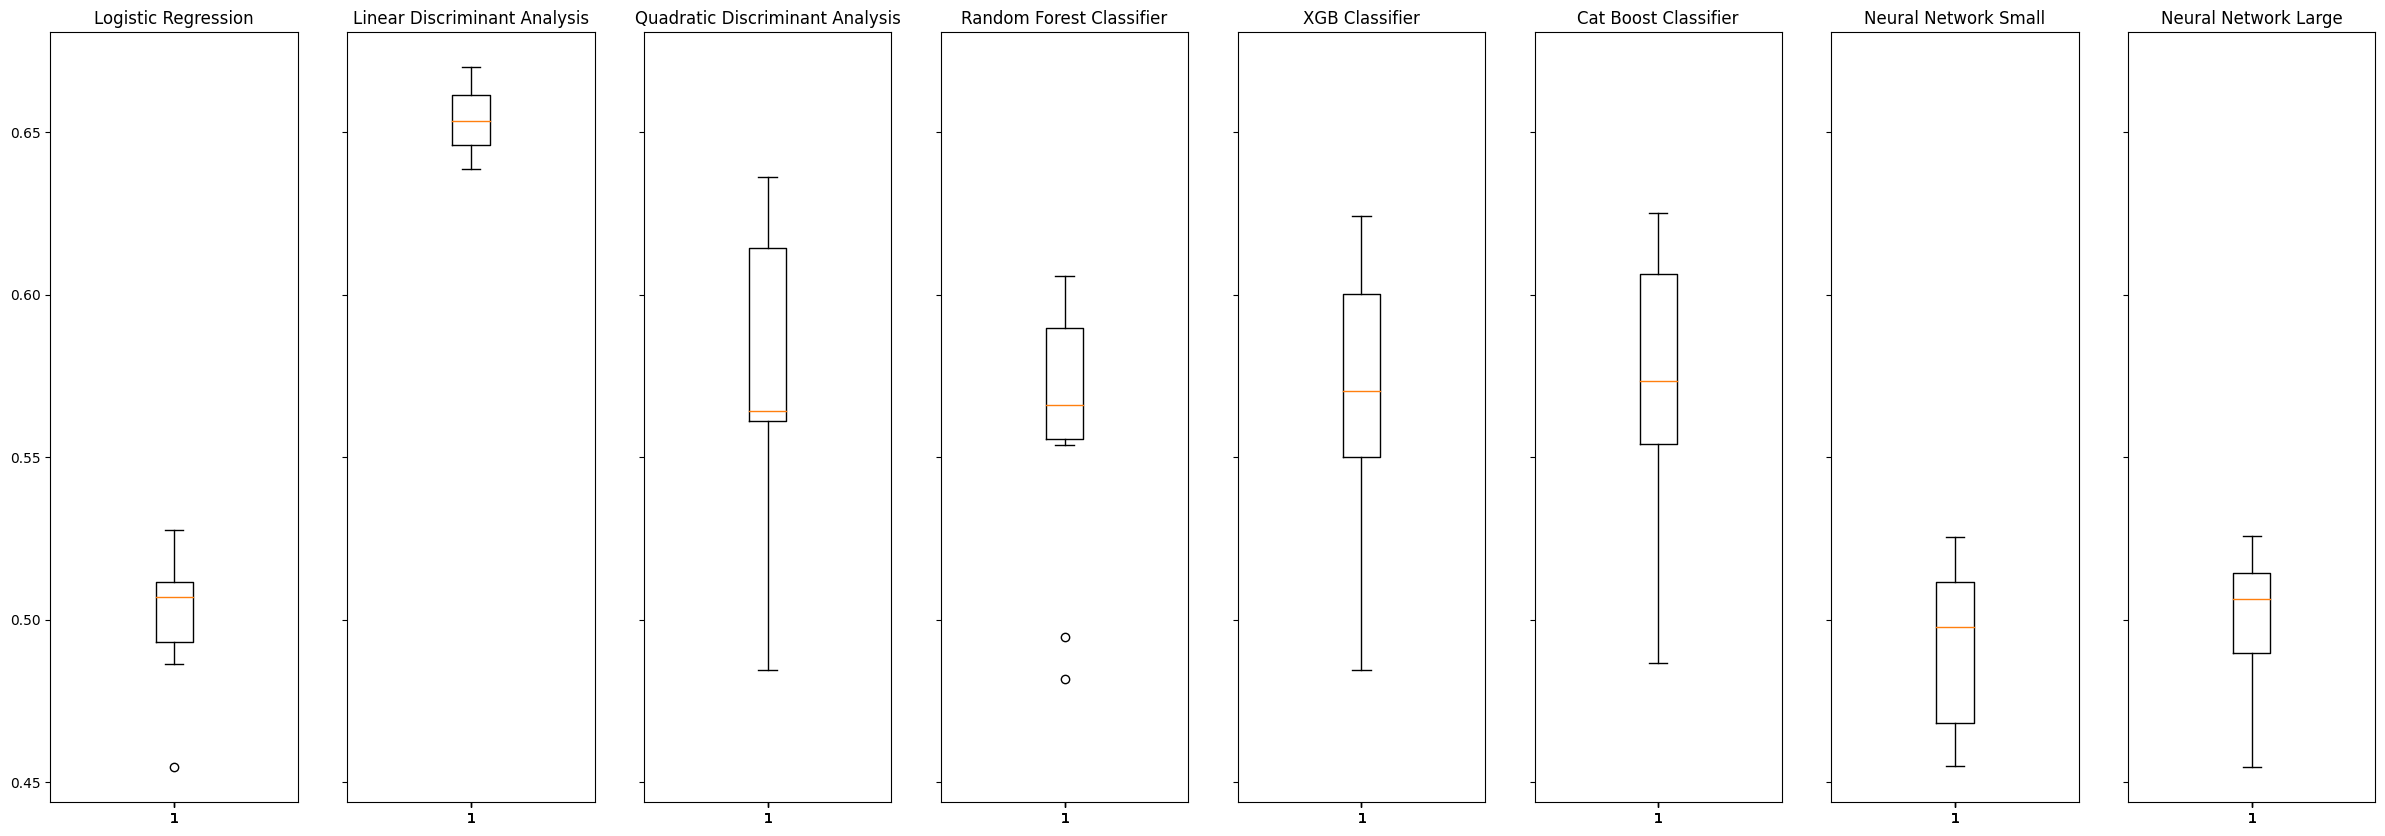

In [68]:
fig,axs = plt.subplots(1,8,sharex=True,sharey=True,figsize=(30,10))

for i,ax in enumerate(axs.flat):
    ax.boxplot(error_ma_crossover.iloc[:,i])
    ax.set_title(models[i])

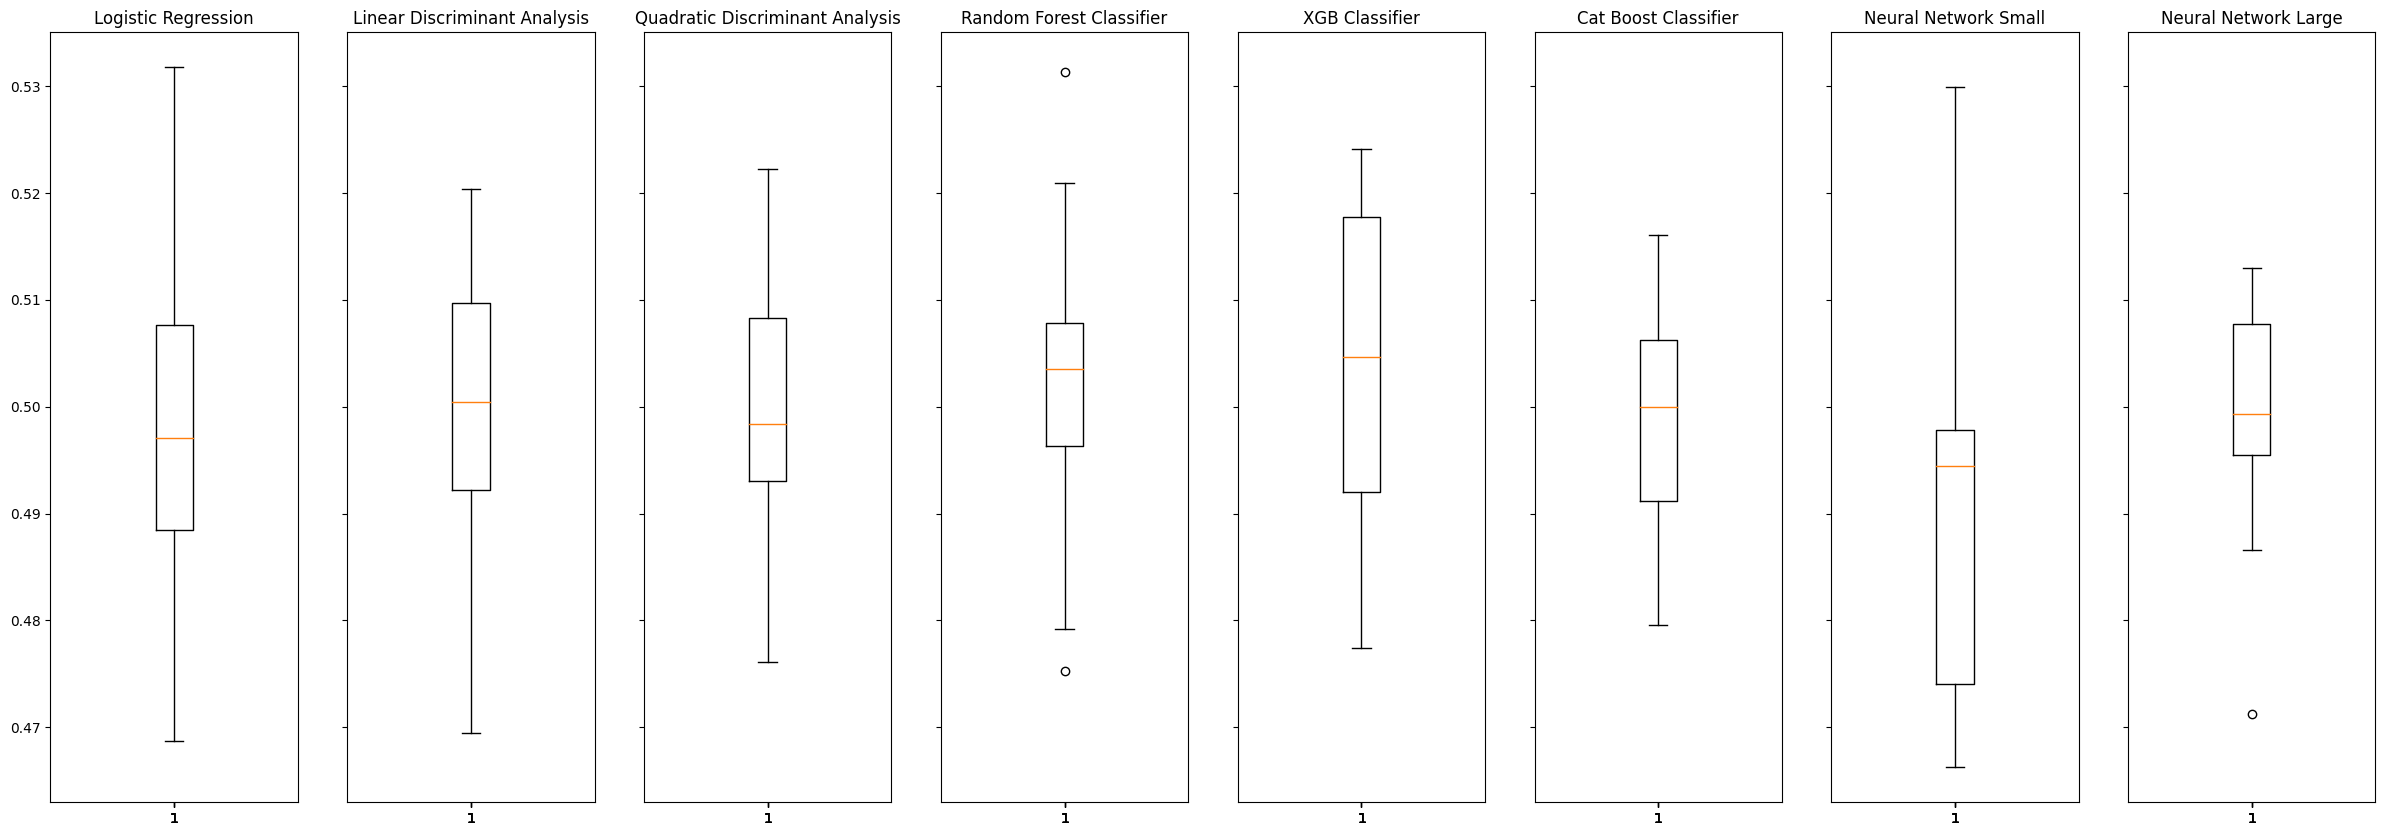

In [69]:
fig,axs = plt.subplots(1,8,sharex=True,sharey=True,figsize=(30,10))

for i,ax in enumerate(axs.flat):
    ax.boxplot(error_price.iloc[:,i])
    ax.set_title(models[i])

Confusion Matrices

Logistic Regression

Text(50.722222222222214, 0.5, 'True')

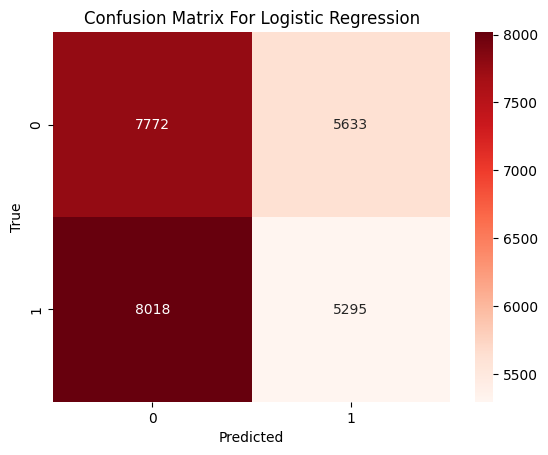

In [322]:
model = LogisticRegression()
model.fit(market_data.loc[49:1000,predictors],market_data.loc[49:1000,"target"])
cm = confusion_matrix(market_data.loc[1030:,"target"], model.predict(market_data.loc[1030:,predictors]))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix For Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')

Linear Discriminant Analysis

Text(50.722222222222214, 0.5, 'True')

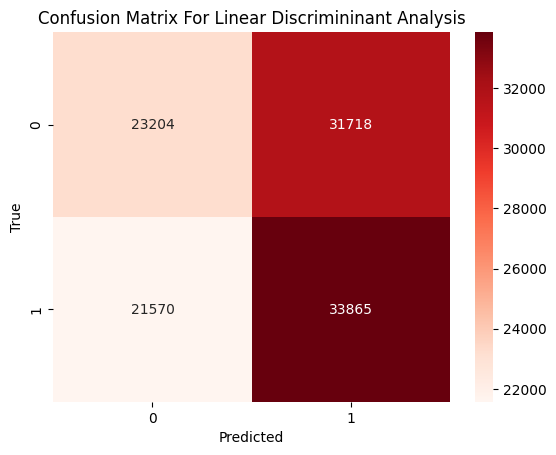

In [70]:
model = LinearDiscriminantAnalysis()
model.fit(market_data.loc[49:1000,predictors],market_data.loc[49:1000,"target"])
cm = confusion_matrix(market_data.loc[1030:,"target"], model.predict(market_data.loc[1030:,predictors]))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix For Linear Discrimininant Analysis')
plt.xlabel('Predicted')
plt.ylabel('True')

XGB Classifier

Text(50.722222222222214, 0.5, 'True')

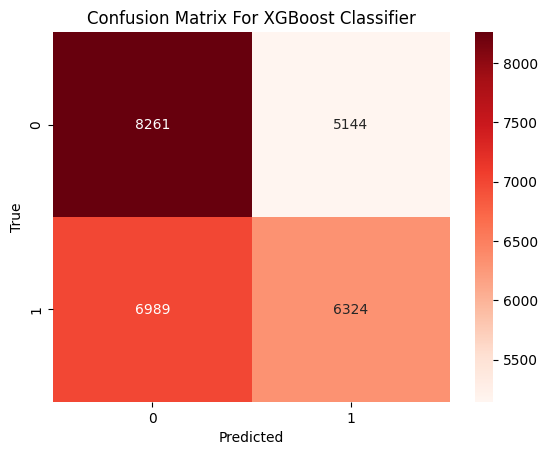

In [324]:
model = XGBClassifier()
model.fit(market_data.loc[49:1000,predictors],market_data.loc[49:1000,"target"])
cm = confusion_matrix(market_data.loc[1030:,"target"], model.predict(market_data.loc[1030:,predictors]))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix For XGBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')

Small Neural Network

Text(50.722222222222214, 0.5, 'True')

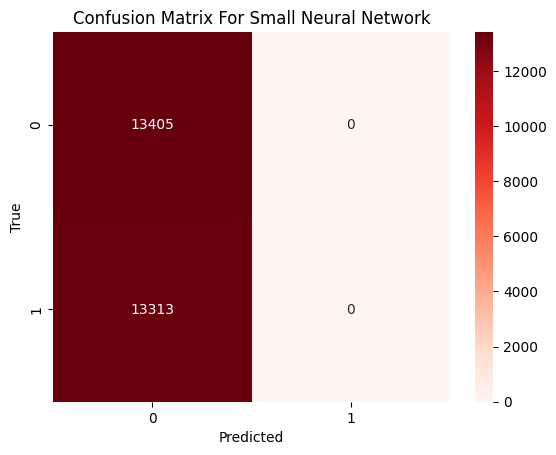

In [325]:
model = MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(4, 2), random_state=1)
model.fit(market_data.loc[49:1000,predictors],market_data.loc[49:1000,"target"])
cm = confusion_matrix(market_data.loc[1030:,"target"], model.predict(market_data.loc[1030:,predictors]))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix For Small Neural Network')
plt.xlabel('Predicted')
plt.ylabel('True')

Learning Curve

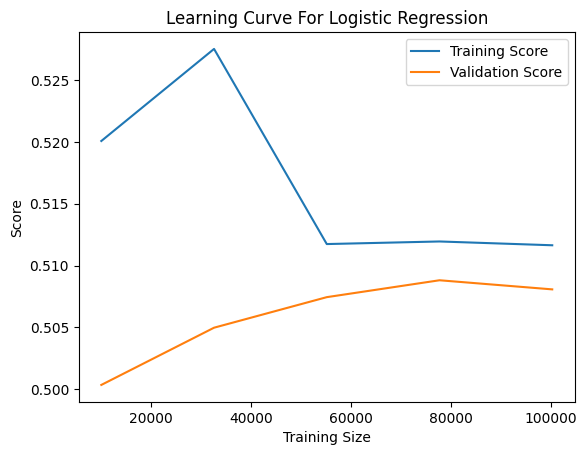

In [73]:
model = LogisticRegression()
train_sizes, train_scores, test_scores = learning_curve(model, market_data.loc[:,predictors],market_data.loc[:,"target"], cv=10)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve For Logistic Regression')
plt.legend()
plt.show()

Linear Discriminant Analysis

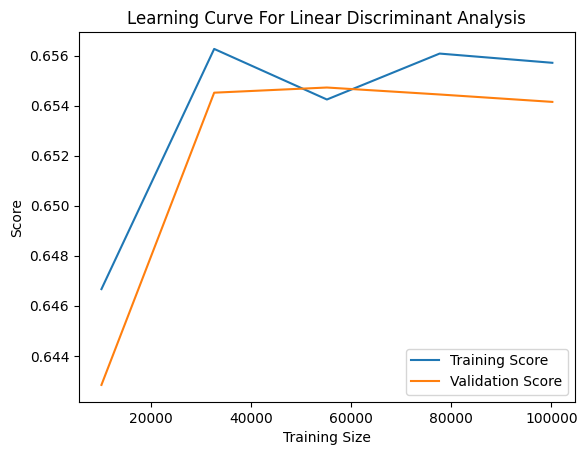

In [71]:
model = LinearDiscriminantAnalysis()
train_sizes, train_scores, test_scores = learning_curve(model, market_data.loc[:,predictors],market_data.loc[:,"target"], cv=10)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve For Linear Discriminant Analysis')
plt.legend()
plt.show()

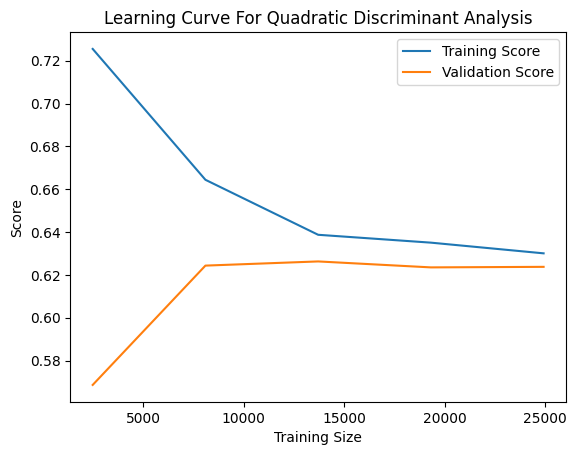

In [348]:
model = QuadraticDiscriminantAnalysis()
train_sizes, train_scores, test_scores = learning_curve(model, market_data.loc[:,predictors],market_data.loc[:,"target"], cv=10)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve For Quadratic Discriminant Analysis')
plt.legend()
plt.show()

Learning rate set to 0.015215
0:	learn: 0.6901168	total: 2.62ms	remaining: 2.61s
1:	learn: 0.6869253	total: 5.32ms	remaining: 2.65s
2:	learn: 0.6847151	total: 7.88ms	remaining: 2.62s
3:	learn: 0.6817348	total: 9.88ms	remaining: 2.46s
4:	learn: 0.6781873	total: 11.8ms	remaining: 2.36s
5:	learn: 0.6747423	total: 13.9ms	remaining: 2.31s
6:	learn: 0.6716780	total: 15.9ms	remaining: 2.26s
7:	learn: 0.6689068	total: 18.1ms	remaining: 2.24s
8:	learn: 0.6662588	total: 20.1ms	remaining: 2.21s
9:	learn: 0.6639580	total: 22ms	remaining: 2.18s
10:	learn: 0.6618002	total: 24ms	remaining: 2.16s
11:	learn: 0.6593745	total: 26ms	remaining: 2.14s
12:	learn: 0.6568742	total: 28ms	remaining: 2.12s
13:	learn: 0.6535682	total: 30ms	remaining: 2.11s
14:	learn: 0.6514274	total: 32ms	remaining: 2.1s
15:	learn: 0.6490441	total: 34.2ms	remaining: 2.1s
16:	learn: 0.6470650	total: 36.5ms	remaining: 2.11s
17:	learn: 0.6446484	total: 38.9ms	remaining: 2.12s
18:	learn: 0.6432532	total: 41.1ms	remaining: 2.12s
19:	le

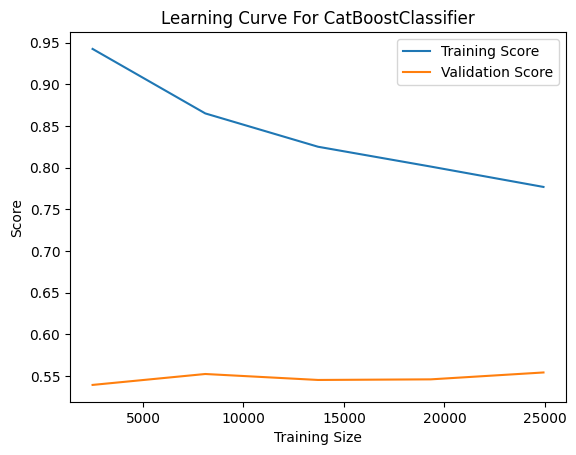

In [349]:
model =CatBoostClassifier()
train_sizes, train_scores, test_scores = learning_curve(model, market_data.loc[:,predictors],market_data.loc[:,"target"], cv=10)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve For CatBoostClassifier')
plt.legend()
plt.show()

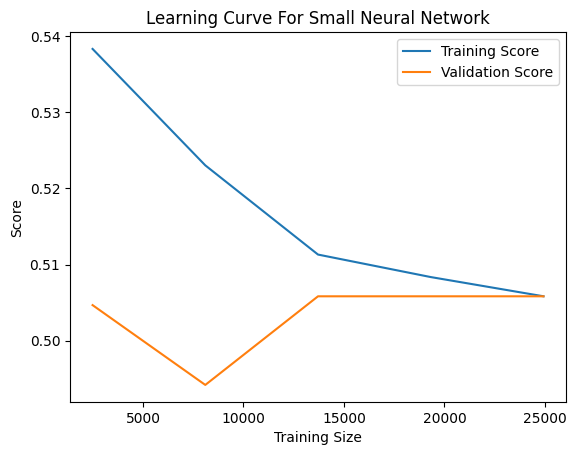

In [333]:
model = MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(6, 4), random_state=1)
train_sizes, train_scores, test_scores = learning_curve(model, market_data.loc[:,predictors],market_data.loc[:,"target"], cv=10)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve For Small Neural Network')
plt.legend()
plt.show()

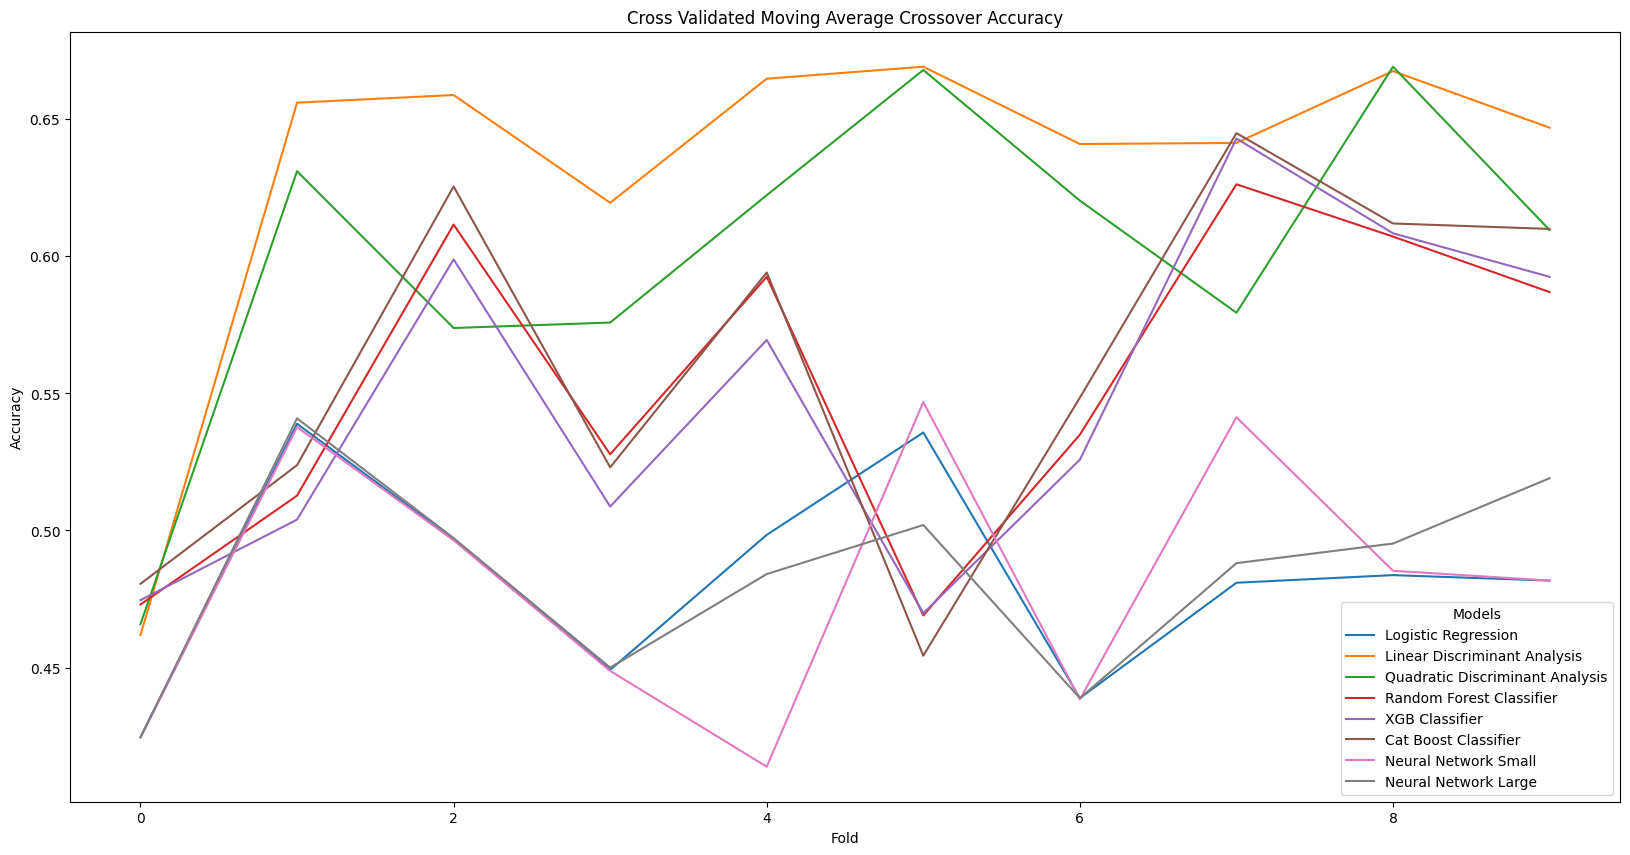

In [359]:
plt.figure(figsize=(20, 10))

# Plot each column separately
for column in error_ma_crossover.columns:
    plt.plot(error_ma_crossover.index, error_ma_crossover[column], label=column)

plt.title('Cross Validated Moving Average Crossover Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend(title='Models')
plt.show()

Feature Selection

In [74]:
from mlxtend.feature_selection import SequentialFeatureSelector

In [75]:
backward_feature_selector = SequentialFeatureSelector(LinearDiscriminantAnalysis(),
                                                      k_features=(1,market_data.loc[:,predictors].shape[1]),
                                                      forward=False,
                                                      verbose=2,
                                                      scoring="accuracy",
                                                      cv=5,
                                                      n_jobs=-1
                                                     ).fit(market_data.loc[:,predictors],market_data.loc[:,"target"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    8.0s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    8.0s finished

[2024-06-25 13:39:26] Features: 7/1 -- score: 0.6555713212548889[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s finished

[2024-06-25 13:39:27] Features: 6/1 -- score: 0.6558767034846913[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s finished

[2024-06-25 13:39:28] Features: 5/1 -- score: 0.6558856869995785[Parallel(n_jobs=-1)]: Using backend Lok

In [76]:
backward_feature_selector.k_feature_names_

('open', 'high', 'close', 'SMA_5', 'SMA_50')

Feature Engineering

In [408]:
#Fetch market data
market_data = pd.DataFrame(mt5.copy_rates_range("EURUSD",timeframe,date_start,date_end))
market_data["time"] = pd.to_datetime(market_data["time"],unit='s')
#Add simple moving average technical indicator
market_data.ta.sma(length=5,append=True)
#Add simple moving average technical indicator
market_data.ta.sma(length=50,append=True)
#Add macd
market_data.ta.macd(append=True)
#Add awesome oscilator
market_data.ta.ao(append=True)
#Add aroon
market_data.ta.aroon(append=True)
#Add chaikins comodity index
market_data.ta.cci(append=True)
#Add percent return
market_data.ta.percent_return(append=True)
#Delete missing rows
market_data.dropna(inplace=True)
#Add the target
market_data["target"] = 0
market_data.loc[market_data["SMA_5"].shift(-look_ahead) > market_data["SMA_50"].shift(-look_ahead),"target"] = 1
market_data.loc[market_data["SMA_5"].shift(-look_ahead) < market_data["SMA_50"].shift(-look_ahead),"target"] = 0
#The last rows do not have answers
market_data = market_data[:-look_ahead]
market_data

time     open     high      low    close  tick_volume  \
49    2020-01-05 22:00:00  1.11650  1.11650  1.11589  1.11591          341   
50    2020-01-05 23:00:00  1.11591  1.11678  1.11591  1.11606         2179   
51    2020-01-06 00:00:00  1.11604  1.11685  1.11602  1.11637         1644   
52    2020-01-06 01:00:00  1.11638  1.11656  1.11615  1.11629         1636   
53    2020-01-06 02:00:00  1.11630  1.11672  1.11625  1.11656          843   
...                   ...      ...      ...      ...      ...          ...   
27743 2024-06-17 17:00:00  1.07251  1.07273  1.07233  1.07259         2347   
27744 2024-06-17 18:00:00  1.07259  1.07379  1.07257  1.07364         2992   
27745 2024-06-17 19:00:00  1.07365  1.07365  1.07304  1.07323         2230   
27746 2024-06-17 20:00:00  1.07323  1.07360  1.07323  1.07341          854   
27747 2024-06-17 21:00:00  1.07335  1.07339  1.07290  1.07298          345   

       spread  real_volume     SMA_5    SMA_50  MACD_12_26_9  MACDh_12_26_9  \
49          4            0  1.116224  1.117824     -0.000471       0.000285   
50          1            0  1.116102  1.117746     -0.000430       0.000261   
51          1            0  1.116026  1.117644     -0.000369       0.000257   
52         50            0  1.116052  1.117532     -0.000323       0.000243   
53          1            0  1.116238  1.117426     -0.000262       0.000243   
...       ...          ...       ...       ...           ...            ...   
27743       0            0  1.072114  1.071362      0.000253       0.000345   
27744       0            0  1.072518  1.071365      0.000401       0.000395   
27745       0            0  1.072840  1.071345      0.000480       0.000379   
27746       0            0  1.073076  1.071334      0.000551       0.000360   
27747       5            0  1.073170  1.071312      0.000566       0.000300   

       MACDs_12_26_9   AO_5_34  AROOND_14   AROONU_14  AROONOSC_14  \
49         -0.000756 -0.000153  21.428571   57.142857    35.714286   
50         -0.000691 -0.000191  14.285714   50.000000    35.714286   
51         -0.000626 -0.000145   7.142857   42.857143    35.714286   
52         -0.000566 -0.000083   0.000000   35.714286    35.714286   
53         -0.000505  0.000130   0.000000   28.571429    28.571429   
...              ...       ...        ...         ...          ...   
27743      -0.000093  0.001765  21.428571   92.857143    71.428571   
27744       0.000006  0.001980  14.285714  100.000000    85.714286   
27745       0.000101  0.002197   7.142857   92.857143    85.714286   
27746       0.000191  0.002348   0.000000   85.714286    85.714286   
27747       0.000266  0.002397   0.000000   78.571429    78.571429   

       CCI_14_0.015  PCTRET_1  target  
49        37.081536  0.000251       1  
50        39.632889  0.000134       1  
51        43.126104  0.000278       1  
52        30.383181 -0.000072       1  
53        39.221469  0.000242       1  
...             ...       ...     ...  
27743    136.345246  0.000075       1  
27744    165.138100  0.000979       1  
27745    134.788143 -0.000382       1  
27746    119.441057  0.000168       1  
27747     82.278949 -0.000401       1  

[27699 rows x 20 columns]

In [413]:
market_data.iloc[:,1:-1]

open     high      low    close  tick_volume  spread  real_volume  \
49     1.11650  1.11650  1.11589  1.11591          341       4            0   
50     1.11591  1.11678  1.11591  1.11606         2179       1            0   
51     1.11604  1.11685  1.11602  1.11637         1644       1            0   
52     1.11638  1.11656  1.11615  1.11629         1636      50            0   
53     1.11630  1.11672  1.11625  1.11656          843       1            0   
...        ...      ...      ...      ...          ...     ...          ...   
27743  1.07251  1.07273  1.07233  1.07259         2347       0            0   
27744  1.07259  1.07379  1.07257  1.07364         2992       0            0   
27745  1.07365  1.07365  1.07304  1.07323         2230       0            0   
27746  1.07323  1.07360  1.07323  1.07341          854       0            0   
27747  1.07335  1.07339  1.07290  1.07298          345       5            0   

          SMA_5    SMA_50  MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  \
49     1.116224  1.117824     -0.000471       0.000285      -0.000756   
50     1.116102  1.117746     -0.000430       0.000261      -0.000691   
51     1.116026  1.117644     -0.000369       0.000257      -0.000626   
52     1.116052  1.117532     -0.000323       0.000243      -0.000566   
53     1.116238  1.117426     -0.000262       0.000243      -0.000505   
...         ...       ...           ...            ...            ...   
27743  1.072114  1.071362      0.000253       0.000345      -0.000093   
27744  1.072518  1.071365      0.000401       0.000395       0.000006   
27745  1.072840  1.071345      0.000480       0.000379       0.000101   
27746  1.073076  1.071334      0.000551       0.000360       0.000191   
27747  1.073170  1.071312      0.000566       0.000300       0.000266   

        AO_5_34  AROOND_14   AROONU_14  AROONOSC_14  CCI_14_0.015  PCTRET_1  
49    -0.000153  21.428571   57.142857    35.714286     37.081536  0.000251  
50    -0.000191  14.285714   50.000000    35.714286     39.632889  0.000134  
51    -0.000145   7.142857   42.857143    35.714286     43.126104  0.000278  
52    -0.000083   0.000000   35.714286    35.714286     30.383181 -0.000072  
53     0.000130   0.000000   28.571429    28.571429     39.221469  0.000242  
...         ...        ...         ...          ...           ...       ...  
27743  0.001765  21.428571   92.857143    71.428571    136.345246  0.000075  
27744  0.001980  14.285714  100.000000    85.714286    165.138100  0.000979  
27745  0.002197   7.142857   92.857143    85.714286    134.788143 -0.000382  
27746  0.002348   0.000000   85.714286    85.714286    119.441057  0.000168  
27747  0.002397   0.000000   78.571429    78.571429     82.278949 -0.000401  

[27699 rows x 18 columns]

In [416]:
backward_feature_selector = SequentialFeatureSelector(LinearDiscriminantAnalysis(),
                                                      k_features=(1,market_data.loc[:,predictors].shape[1]),
                                                      forward=False,
                                                      verbose=2,
                                                      scoring="accuracy",
                                                      cv=5,
                                                      n_jobs=-1
                                                     ).fit(market_data.iloc[:,1:-1],market_data.loc[:,"target"])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.7s finished

[2024-06-18 21:27:10] Features: 17/1 -- score: 0.6758005947977681[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.2s finished

[2024-06-18 21:27:13] Features: 16/1 -- score: 0.6760171817431108[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.9s finished

[2024-06-18 21:27:16] Features: 15/1 -- score: 0.6760532763085259[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [417]:
backward_feature_selector.k_feature_names_

('close',
 'tick_volume',
 'spread',
 'SMA_5',
 'SMA_50',
 'MACDh_12_26_9',
 'AO_5_34')

Building our trading algorithm

In [25]:
#Fetch market data
market_data = pd.DataFrame(mt5.copy_rates_range("EURUSD",timeframe,date_start,date_end))
market_data["time"] = pd.to_datetime(market_data["time"],unit='s')
predictors = ['close','tick_volume','spread','SMA_5','SMA_50','MACDh_12_26_9','AO_5_34']
#Add simple moving average technical indicator
market_data.ta.sma(length=5,append=True)
#Add simple moving average technical indicator
market_data.ta.sma(length=50,append=True)
#Add macd
market_data.ta.macd(append=True)
#Add awesome oscilator
market_data.ta.ao(append=True)
#Add aroon
market_data.ta.aroon(append=True)
#Add chaikins comodity index
market_data.ta.cci(append=True)
#Add percent return
market_data.ta.percent_return(append=True)
#Delete missing rows
market_data.dropna(inplace=True)
#Add the target
#Encoding the target
ma_cross_conditions = [
    (market_data["SMA_5"].shift(-look_ahead) > market_data["SMA_50"].shift(-look_ahead)),
    (market_data["SMA_5"].shift(-look_ahead) < market_data["SMA_50"].shift(-look_ahead))
]
#Encoding pattern
ma_cross_choices = [
    #Fast MA above Slow MA
    1,
    #Fast MA below Slow MA
    0
]
market_data["target"] = np.select(ma_cross_conditions,ma_cross_choices)
#The last rows do not have answers
market_data = market_data[:-look_ahead]

In [29]:
model = LinearDiscriminantAnalysis()
model.fit(market_data.loc[:,predictors],market_data.loc[:,"target"])

LinearDiscriminantAnalysis()

In [93]:
def get_prices():
    start = datetime(2024,6,1)
    end   = datetime.now()
    data  = pd.DataFrame(mt5.copy_rates_range("EURUSD",timeframe,start,end))
    #Add simple moving average technical indicator
    data.ta.sma(length=5,append=True)
    data.ta.sma(length=50,append=True)
    #Add awesome oscilator
    data.ta.ao(append=True)
    #Add macd
    data.ta.macd(append=True)
    #Delete missing rows
    data.dropna(inplace=True)
    data['time'] = pd.to_datetime(data['time'],unit='s')
    data.set_index('time',inplace=True)
    data = data.loc[:,['close','tick_volume','spread','SMA_5','SMA_50','MACDh_12_26_9','AO_5_34']]
    data = data.iloc[-2:,:]
    return(data)

In [101]:
#Get signals LDA model
def ai_signal(input_data,_model):
    #Get a forecast
    forecast = _model.predict(input_data)
    return forecast[1]

In [ ]:
#Now we define the main body of our Python Moving Average Crossover Trading Bot
if __name__ == '__main__':
    #We'll use an infinite loop to keep the program running
    while True:
        #Fetching model prediction
        signal = ai_signal(get_prices(),model)
        
        #Decoding model prediction into an action
        if signal == 1:
            direction = 'buy'
        elif signal == 0:
            direction = 'sell'
        
        print(f'AI Forecast: {direction}')
        
        #Opening A Buy Trade
        #But first we need to ensure there are no opposite trades open on the same symbol
        if direction == 'buy':
            #Close any sell positions
            for pos in mt5.positions_get():
                if pos.type == 1:
                    #This is an open sell order, and we need to close it
                    close_order(pos.ticket)
            
            if not mt5.positions_totoal():
                #We have no open positions
                mt5.Buy(symbol,volume)
        
        #Opening A Sell Trade
        elif direction == 'sell':
            #Close any buy positions
            for pos in mt5.positions_get():
                if pos.type == 0:
                    #This is an open buy order, and we need to close it
                    close_order(pos.ticket)
            
            if not mt5.positions_get():
                #We have no open positions
                mt5.sell(symbol,volume)
        
        print('time: ', datetime.now())
        print('-------\n')
        time.sleep(60)

AI Forecast: sell
time:  2024-06-25 14:35:37.954923
-------

AI Forecast: sell
time:  2024-06-25 14:36:37.966616
-------

AI Forecast: sell
time:  2024-06-25 14:37:37.975907
-------

AI Forecast: sell
time:  2024-06-25 14:38:37.984652
-------

AI Forecast: sell
time:  2024-06-25 14:39:37.995651
-------

AI Forecast: sell
time:  2024-06-25 14:40:38.005821
-------

AI Forecast: sell
time:  2024-06-25 14:41:38.015478
-------

